In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.


In [6]:
df = pd.read_csv('AirPassengers.csv')
df.set_index('Month', inplace=True)
df.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


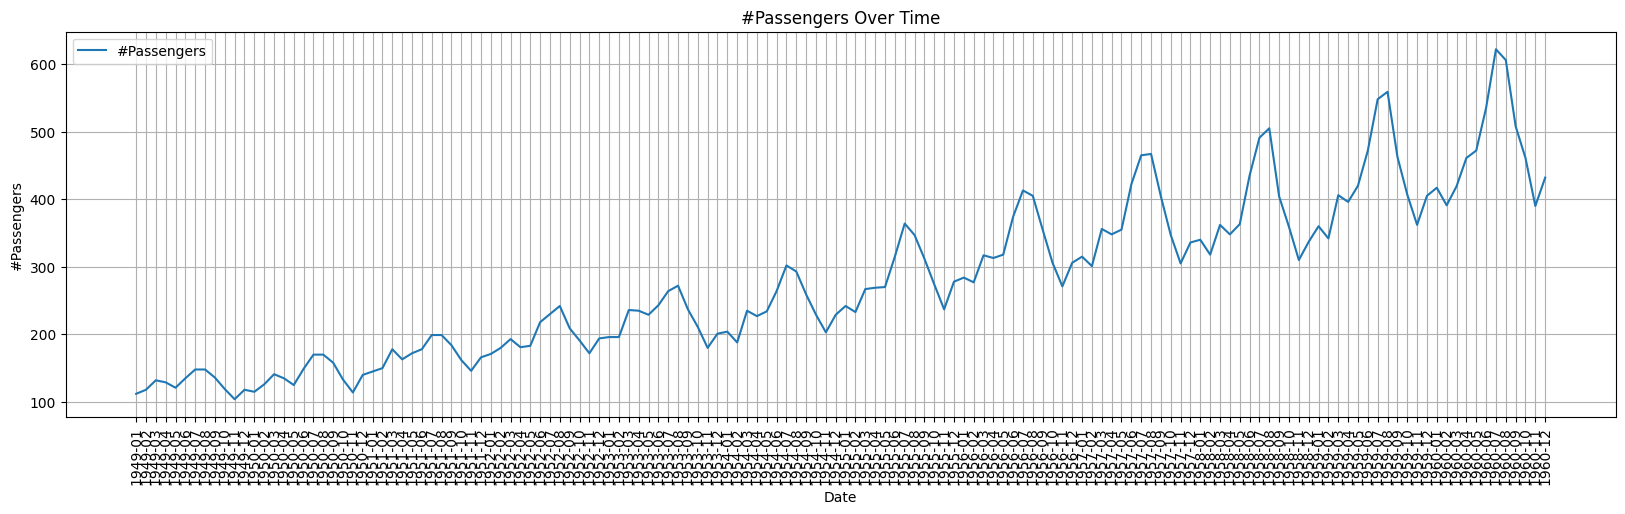

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['#Passengers'], label='#Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.title('#Passengers Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [8]:
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)

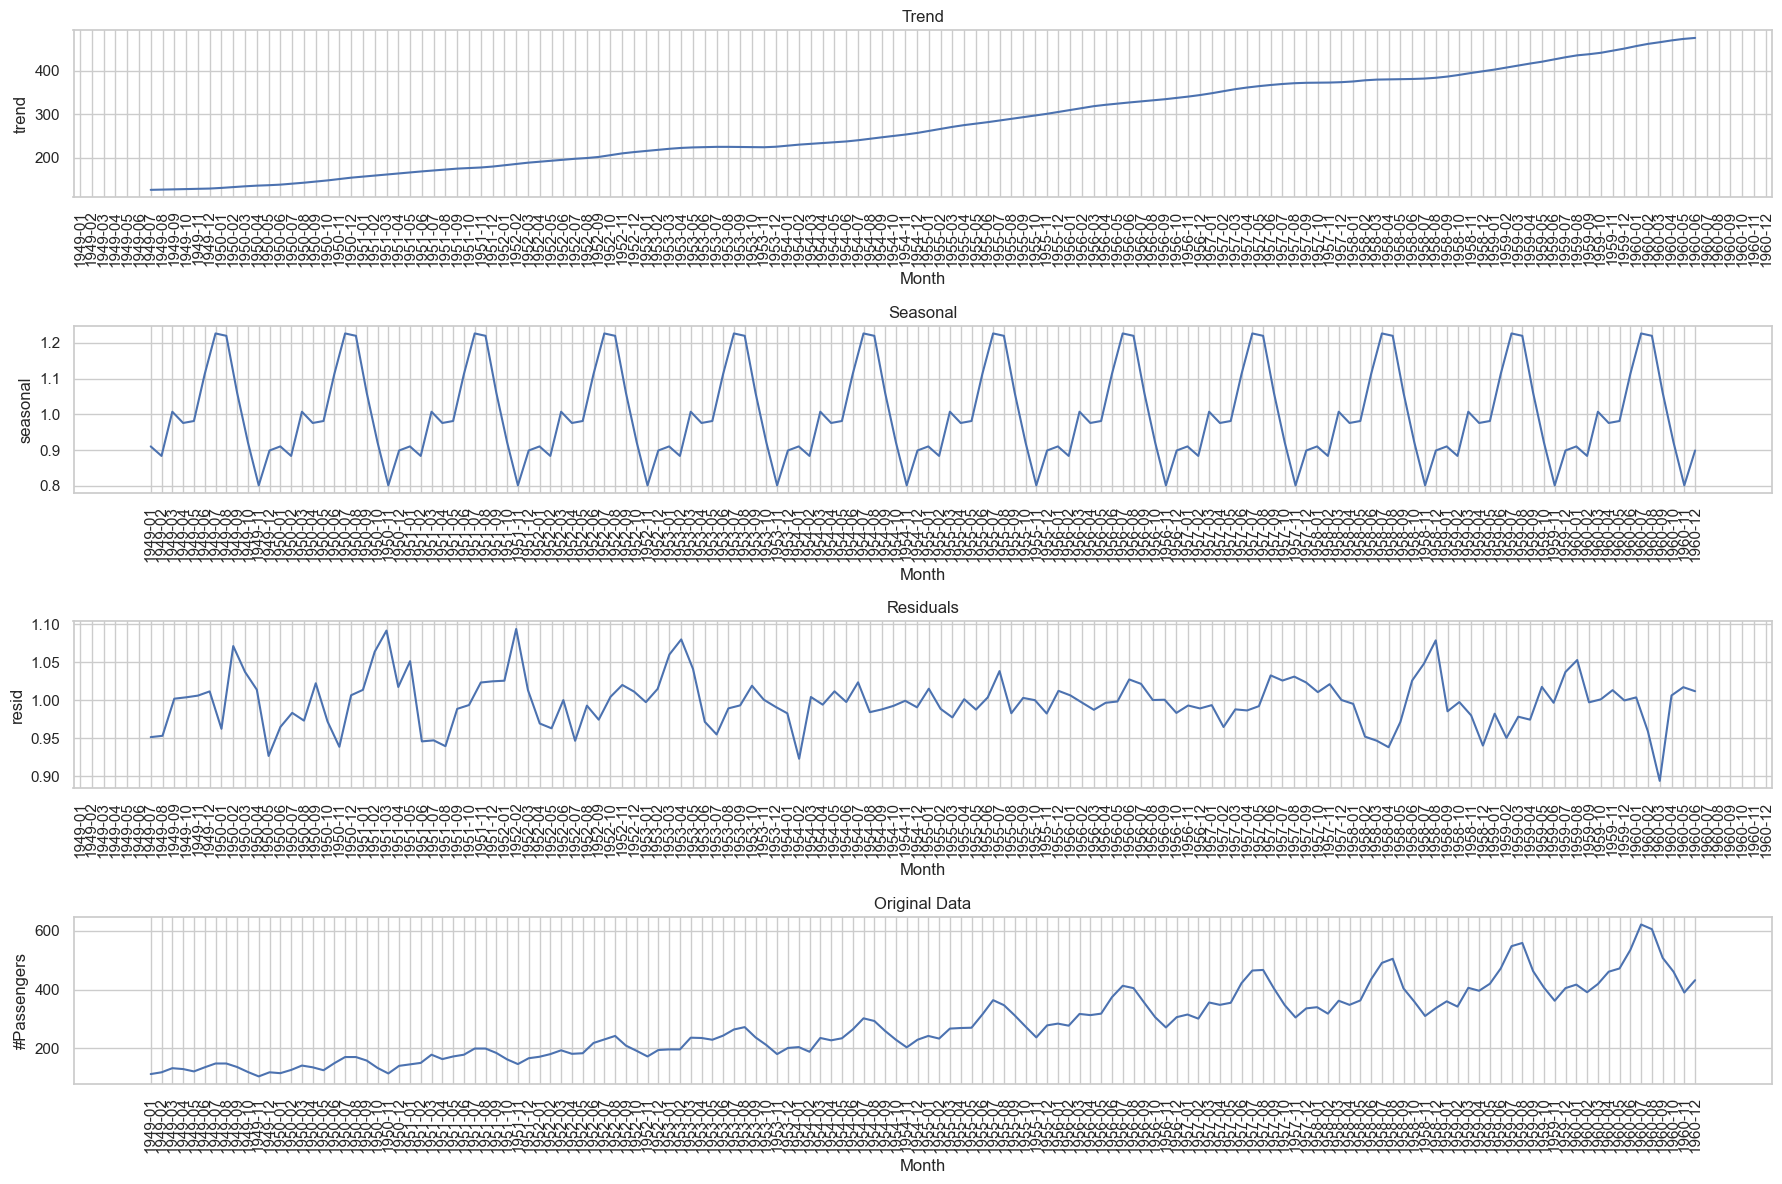

In [9]:
# plot the components in the graph
sns.set(style='whitegrid')

plt.figure(figsize=(18,12))

# trend component
plt.subplot(411)
sns.lineplot(data=result.trend)
plt.title('Trend')
plt.xticks(rotation=90)

# seasonal component
plt.subplot(412)
sns.lineplot(data=result.seasonal)
plt.title('Seasonal')
plt.xticks(rotation=90)

# Residuals component
plt.subplot(413)
sns.lineplot(data=result.resid)
plt.title('Residuals')
plt.xticks(rotation=90)

# Original data
plt.subplot(414)
sns.lineplot(data=df['#Passengers'])
plt.title('Original Data')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [10]:
seasonal_period = 12

In [11]:
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test

result = adfuller(df['#Passengers'], autolag='AIC') # Akaike Information Criterion
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.815368879206052
p-value: 0.991880243437641


In [12]:
# first order differencing
result = adfuller(df['#Passengers'].diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


In [13]:
# second order differencing
result = adfuller(df['#Passengers'].diff().diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -16.384231542468488
p-value: 2.732891850014319e-29


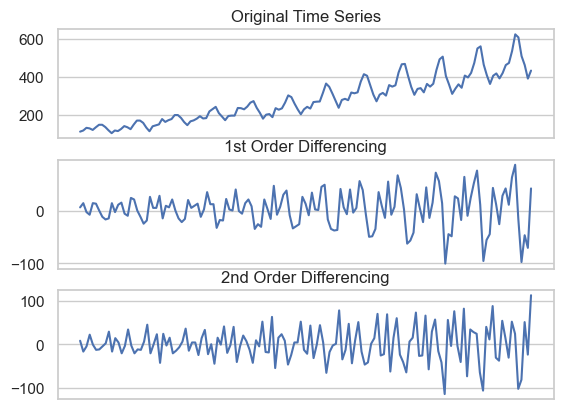

In [14]:
# plot the differencing values
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(df)
ax1.set_title('Original Time Series')
ax1.axes.xaxis.set_visible(False)

ax2.plot(df.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

ax3.plot(df.diff().diff())
ax3.set_title('2nd Order Differencing')
ax3.axes.xaxis.set_visible(False)

plt.show()

In [16]:
# the time series becomes stationary after first order differencing

In [15]:
# p = 0 # MA - Moving Average - PACF
# d = 1 # order of differencing - I
# q = 0 # AR - Auto Regressive - ACF

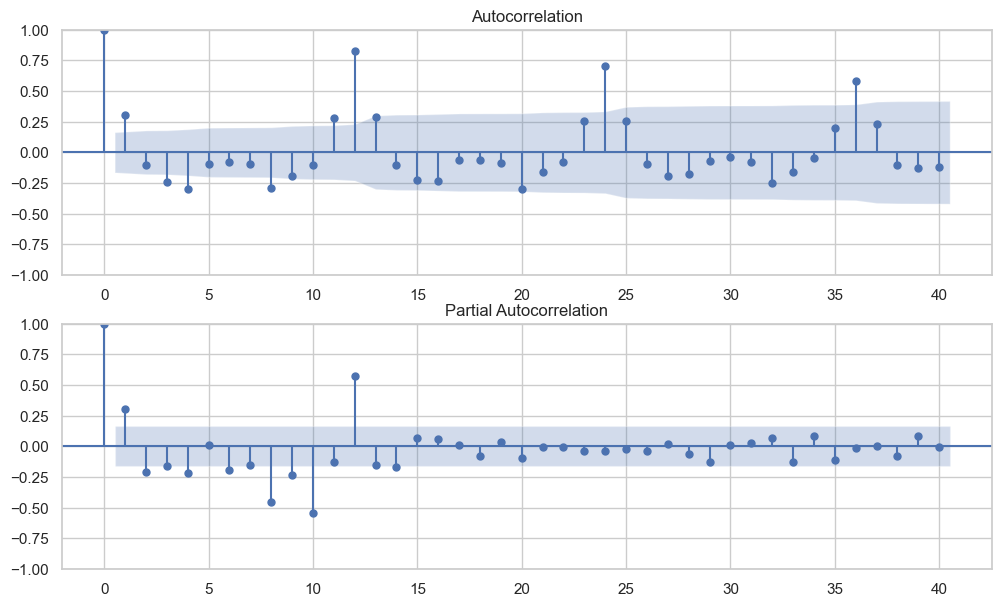

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7))
sm.graphics.tsa.plot_acf(df.diff().dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df.diff().dropna(), lags=40, ax=ax[1])
plt.show()

In [19]:
p = 2 # pacf
d = 1 # 1st order difference
q = 1 # acf

In [20]:
P = 1
D = 0
Q = 3

In [21]:
# define the arima model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['#Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
fitted_model = model.fit()
print(fitted_model.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78523D+00    |proj g|=  7.11094D-01

At iterate    5    f=  4.48405D+00    |proj g|=  2.44150D-02

At iterate   10    f=  4.28952D+00    |proj g|=  7.51132D-02

At iterate   15    f=  3.95496D+00    |proj g|=  5.69130D-02

At iterate   20    f=  3.94386D+00    |proj g|=  3.79804D-02

At iterate   25    f=  3.92378D+00    |proj g|=  1.87089D-02

At iterate   30    f=  3.91762D+00    |proj g|=  3.32675D-03

At iterate   35    f=  3.91680D+00    |proj g|=  1.83793D-02

At iterate   40    f=  3.91142D+00    |proj g|=  6.90265D-03

At iterate   45    f=  3.91128D+00    |proj g|=  1.88019D-03

At iterate   50    f=  3.91128D+00    |proj g|=  2.81061D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [22]:
# forecast for next 2 years
forecast_steps = 24
forecast = fitted_model.get_forecast(steps=forecast_steps)

# create the date range for the forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:].strftime('%Y-%m') # remove start date

In [23]:
# create a forecast dataframe
forecast_df = pd.DataFrame({
    "Forecast": list(forecast.predicted_mean),
    "Lower CI": list(forecast.conf_int().iloc[:, 0]),
    "Upper CI": list(forecast.conf_int().iloc[:, 1])
}, index=forecast_index)

forecast_df.head()

,Forecast,Lower CI,Upper CI
1961-01,446.723412,424.876104,468.570721
1961-02,423.349190,397.210412,449.487968
1961-03,456.473638,426.856816,486.090459
1961-04,491.594764,459.563762,523.625767
1961-05,505.166284,471.286432,539.046135


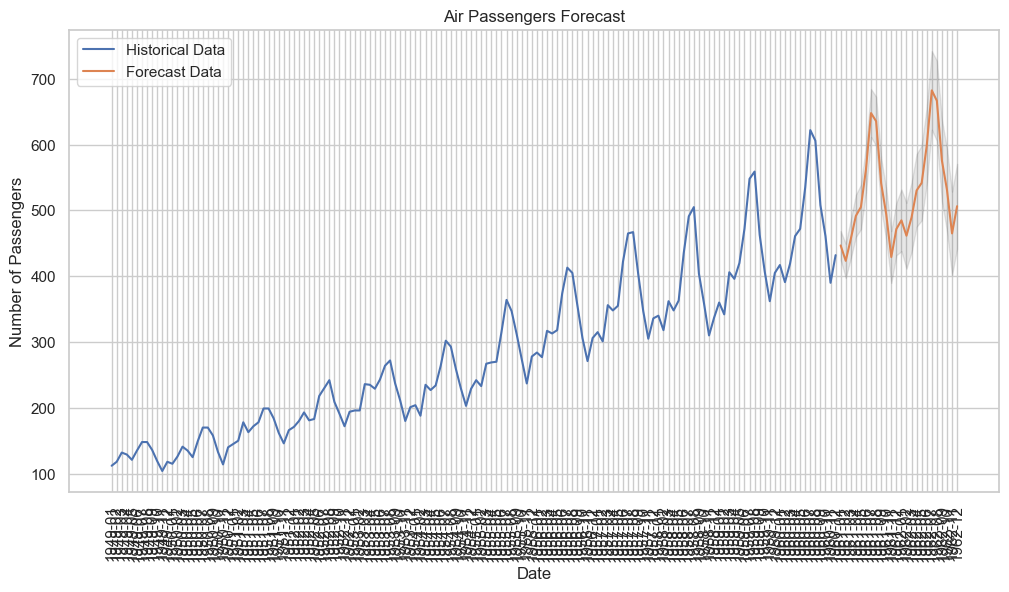

In [24]:
# plot the forecast values

plt.figure(figsize=(12, 6))
plt.plot(df['#Passengers'], label='Historical Data')
plt.plot(forecast_df['Forecast'], label='Forecast Data')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Air Passengers Forecast')
plt.xticks(rotation=90)
plt.legend()
plt.show()